# 1D CNN text classifier

### imports

In [44]:
import csv, time, random, copy, string
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score


In [45]:
random.seed(0)
torch.manual_seed(0)

train_dataset_path = "datasets/train_dataset_128.csv"
val_dataset_path = "datasets/val_dataset_128.csv"

BATCH_SIZE = 16
MAX_LEN = 128
LEARNING_RATE = 1e-3
EPOCHS = 5
max_adv_ite = 100

## Dataset

In [46]:
def load_csv_dataset(path):
    texts = []
    labels = []

    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            texts.append(row["text"])
            labels.append(int(row["label"]))

    return texts, labels

In [47]:
class TextDataset(Dataset):
    def __init__(self, samples, labels, max_len=MAX_LEN):
        self.samples = samples
        self.labels = labels
        self.max_len = max_len

    def encode(self, s):
        # byte encoding, values 0–255
        x = list(s.encode("utf-8"))[:self.max_len]
        # pad with zeros
        pad_len = self.max_len - len(x)
        x = x + [0] * pad_len
        return torch.tensor(x, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.encode(self.samples[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

train_texts, train_labels = load_csv_dataset(train_dataset_path)
train_loader = DataLoader(
    TextDataset(train_texts, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_texts, val_labels = load_csv_dataset(val_dataset_path)
val_loader = DataLoader(
    TextDataset(val_texts, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Base model

### Model definition

In [48]:
class CharCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=32,
        num_filters=128,
        kernel_sizes=(3, 5, 7),
        dropout=0.2,
        num_classes=1  # binary classification
    ):
        super().__init__()

        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Multiple convolution branches
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k
            ) for k in kernel_sizes
        ])

        # Final classifier
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        """
        x: (batch_size, seq_len) - tensor of character IDs
        """
        embedded = self.embedding(x)  # (batch, seq, embed)
        embedded = embedded.transpose(1, 2)  # (batch, embed, seq)

        # Apply conv → ReLU → global max pool
        conv_results = []
        for conv in self.convs:
            c = conv(embedded)                 # (batch, filters, seq')
            c = F.relu(c)
            c = F.max_pool1d(c, kernel_size=c.size(2))  # global max pool
            conv_results.append(c.squeeze(2))

        # Concatenate features
        features = torch.cat(conv_results, dim=1)

        out = self.dropout(features)
        out = self.fc(out)

        # Output logits (use BCEWithLogitsLoss)
        return out

#### Visualization

In [49]:
model = CharCNN(vocab_size=MAX_LEN)
print(model)

CharCNN(
  (embedding): Embedding(128, 32, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(32, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(32, 128, kernel_size=(5,), stride=(1,))
    (2): Conv1d(32, 128, kernel_size=(7,), stride=(1,))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=384, out_features=1, bias=True)
)


### Training

In [50]:
model = CharCNN(vocab_size=MAX_LEN)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
for epoch in range(EPOCHS):
    total_loss = 0
    t0 = time.time()
    for x, y in train_loader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.squeeze(1), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: time {(time.time()-t0):.2f}s, loss = {total_loss:.4f}")

Epoch 1: time 6.21s, loss = 49.1077
Epoch 2: time 6.13s, loss = 2.8205
Epoch 3: time 7.22s, loss = 1.8399
Epoch 4: time 9.49s, loss = 0.6780
Epoch 5: time 8.94s, loss = 0.2617


### Evaluation

In [52]:
def eval_model(model, val_loader):
    model.eval()
    with torch.no_grad():
        for xs, ys in val_loader:
            logits = model(xs)
            probs = torch.sigmoid(logits.squeeze(1))
            preds = (probs > 0.5).long()
            targets = ys.long()

    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=1)
    rec = recall_score(targets, preds, zero_division=1)
    f1 = f1_score(targets, preds, zero_division=1)
    try:
        auc = roc_auc_score(targets, probs)
    except Exception:
        auc = float('nan')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AuC: {auc:.4f}")

In [53]:
eval_model(model, val_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AuC: nan


c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


### Inference

In [54]:
def predict(model, text):
    model.eval()
    x = torch.tensor([c for c in text.encode()][:MAX_LEN] + [0]*(MAX_LEN-len(text)), dtype=torch.long)
    x = x.unsqueeze(0)
    with torch.no_grad():
        p = torch.sigmoid(model(x)).item()
    return p  # close to 1 = real text, close to 0 = random

In [55]:
print(predict(model, "This is a sample of real text (pretty much)."))  # Expected: close to 1
print(predict(model, "akdng lsmehbo sai ownf 1 asfd dmdl"))  # Expected: close to 0

0.9855954647064209
0.008562669157981873


### Adversarial attack

Can we forge a random sequence that gets recognized as real?  
Let's start from a random one and make random changes that improve the score

In [56]:
def random_uniform_like(n):
    """Uniform random characters."""
    chars = string.ascii_lowercase + "   "
    return ''.join(random.choice(chars) for _ in range(n))


def random_markov_like(n):
    """Produce pseudo-word sequences that look a bit structured but are gibberish."""
    consonants = "bcdfghjklmnpqrstvwxyz  "
    vowels = "aeiou  "
    s = ""
    for _ in range(n):
        pattern = random.choice([
            random.choice(consonants),
            random.choice(vowels),
            random.choice(consonants) + random.choice(vowels),
            random.choice(vowels) + random.choice(consonants)
        ])
        s += pattern
    return s[:n]

def adversarial_attack(model, max_ite=200, samples=10, plot=True):
    scores_history = np.zeros((len(range(10,MAX_LEN+1,50)), samples, max_ite))
    j = 0
    for n in range(10,MAX_LEN+1,50):
        for e in range(samples//2):
            rand_seq = random_uniform_like(n)
            score = predict(model, rand_seq)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(model, new_seq)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e, i] = score
        for e in range(samples//2):
            rand_seq = random_markov_like(n)
            score = predict(model, rand_seq)

            for i in range(max_ite):
                chars = "bcdfghjklmnpqrstvwxyz aeiou "
                pos = random.randint(0, len(rand_seq)-1)
                new_char = random.choice(chars)
                new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
                new_score = predict(model, new_seq)
                if new_score > score:
                    rand_seq = new_seq
                    score = new_score
                scores_history[j, e+samples//2, i] = score

        if plot:
            plt.figure(figsize=(4, 3))
            plt.plot(scores_history[j].T)
            # color the area where the string wolud get recognized as real (0.5 threshold)
            plt.fill_between(range(scores_history.shape[2]), 0.5, 1, color='red', alpha=0.2)
            plt.xlabel("Iteration")
            plt.ylabel("Predicted Real Text Score")
            plt.title(f"Evolution of Random Sequence Scores for n={n}")
            plt.show()
        
        j+=1
    return scores_history

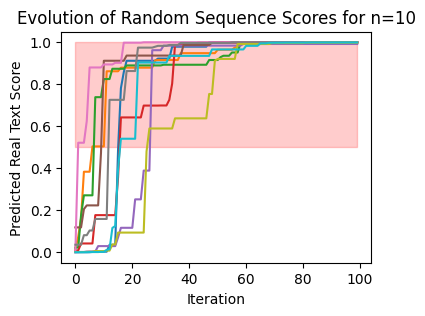

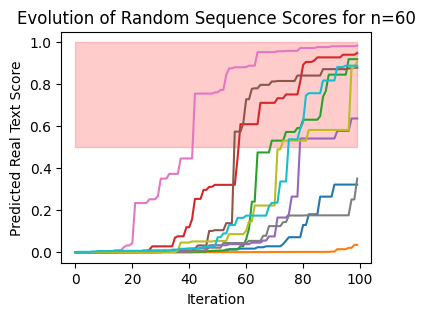

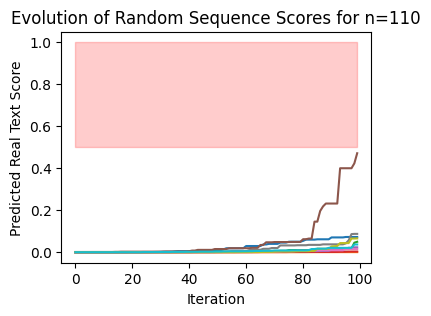

In [57]:
h = adversarial_attack(model, max_ite=max_adv_ite, samples=10, plot=True)

In [58]:
print("Adv @10: ", np.sum(h[0, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @60: ", np.sum(h[1, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @110: ", np.sum(h[2, :, -1] >= 0.5)/len(h[0, :, -1]))

Adv @10:  1.0
Adv @60:  0.7
Adv @110:  0.0


Obtaining a random string that gets classified as real is very easy for short length, a bit more complicated for longer ones:  
this means that the dataset is not good enough or at least that the current model is too weak

Can we use this strategy to generate new sample and retrain the model?   
=> something like boosting

## Second training

In [59]:
first_training_model = copy.deepcopy(model)

### Training

Let's try to train for a few more epochs only with samples generated in this way.
In particular we would like to improve the classification of shorter strings.  

If a second training like this will not show its effectiveness, we will build a new model trained with boosting.

In [60]:
def build_epoch_dataset(model, num_samples, seq_len=MAX_LEN, margin=0.1):
    samples = []
    labels = []

    for _ in range(num_samples//2):
        # rand_length = random.randint(10, seq_len)
        rand_length = seq_len
        method = random.choice(['uniform', 'markov'])
        if method == 'uniform':
            rand_seq = random_uniform_like(rand_length)
        else:
            rand_seq = random_markov_like(rand_length)
        score = predict(model, rand_seq)

        for i in range(200):
            chars = "bcdfghjklmnpqrstvwxyz aeiou "
            pos = random.randint(0, len(rand_seq)-1)
            new_char = random.choice(chars)
            new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
            new_score = predict(model, new_seq)
            if new_score > score:
                rand_seq = new_seq
                score = new_score
            if score > 0.5 + margin:
                break

        samples.append(rand_seq)
        labels.append(0)  # label as random text
        # randomly chose a real text sample from the training data to keep the balance
        samples.append(random.choice(train_texts))
        labels.append(1)

    return samples, labels

def second_training_epoch(model, optimizer, num_samples=200):
    model.train()
    samples, labels = build_epoch_dataset(model, num_samples)
    dataset = TextDataset(samples, labels)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.squeeze(1), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [61]:
model = copy.deepcopy(first_training_model)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
    t0 = time.time()
    loss = second_training_epoch(model, optimizer, num_samples=200)
    print(f"Epoch {epoch+1}: time {(time.time()-t0):.2f}s, loss = {loss:.4f}")

Epoch 1: time 18.18s, loss = 42.9370
Epoch 2: time 18.15s, loss = 39.3349
Epoch 3: time 15.66s, loss = 35.8826
Epoch 4: time 16.85s, loss = 26.9797
Epoch 5: time 17.64s, loss = 20.3679


### Evaluation

Repeat the attack and compare the result

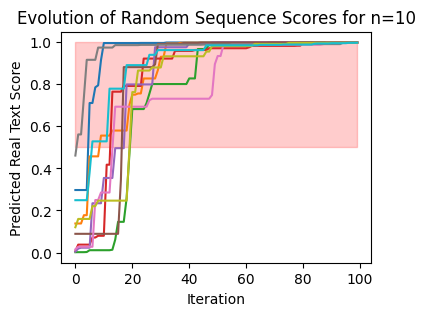

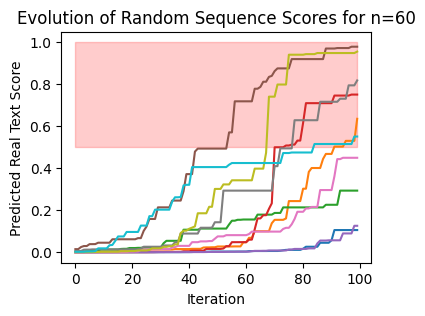

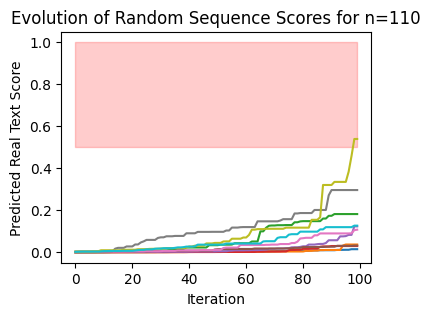

In [62]:
h = adversarial_attack(model, max_ite=max_adv_ite, samples=10, plot=True)

In [63]:
print("Adv @10: ", np.sum(h[0, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @60: ", np.sum(h[1, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @110: ", np.sum(h[2, :, -1] >= 0.5)/len(h[0, :, -1]))

Adv @10:  1.0
Adv @60:  0.6
Adv @110:  0.1


Did the second training affect the overall results?
Yes, inevitably the metrics decreased but arte still reasonable

In [64]:
eval_model(model, val_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AuC: nan


c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


**Results**:  
The second training was effective for both random_uniform and random_markov strings.

Does it make sense though to perform 2 separate training? Can't we just use the second one form the beginning?

## Boosted training

### Boosting-like iterative augmentation
We train for short rounds, evaluate which training samples are misclassified, upsample those errors and add adversarial negatives generated from the model. Repeat to let the model focus on its mistakes.

In [65]:
def evaluate_texts(model, texts, labels, batch_size=64):
    """Return misclassified indices and basic stats."""
    model.eval()
    mis_idx = []
    preds_all = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            xs = torch.stack([TextDataset(batch_texts, batch_labels).encode(s) for s in batch_texts])
            logits = model(xs).squeeze(1)
            probs = torch.sigmoid(logits).cpu().numpy()
            for j, p in enumerate(probs):
                pred = 1 if p>0.5 else 0
                if pred != batch_labels[j]:
                    mis_idx.append(i+j)
                preds_all.append((pred, batch_labels[j], p))
    return mis_idx, preds_all

def _jitter_text(s, max_changes=3):
    """Small random edits to a real text to help generalization."""
    if len(s) == 0:
        return s
    s = list(s)
    for _ in range(random.randint(0, max_changes)):
        op = random.choice(['swap','sub','del','ins'])
        pos = random.randint(0, len(s)-1)
        if op == 'swap' and pos+1 < len(s):
            s[pos], s[pos+1] = s[pos+1], s[pos]
        elif op == 'sub':
            s[pos] = random.choice(string.ascii_letters + ' ')
        elif op == 'del' and len(s)>1:
            s.pop(pos)
        elif op == 'ins':
            s.insert(pos, random.choice(string.ascii_letters + ' '))
    return ''.join(s)[:MAX_LEN]

def augment_training_set(train_texts, train_labels, mis_idx, model, upsample_factor=2, adv_negatives=100, max_total=None):
    """Upsample misclassified examples, jitter some positives, and add adversarial negatives generated from the provided model.
    Caps total dataset size if max_total is provided to avoid runaway growth."""
    new_texts = list(train_texts)
    new_labels = list(train_labels)

    # Upsample misclassified samples (keep same label)
    for idx in mis_idx:
        for _ in range(upsample_factor-1):  # we already have one copy
            new_texts.append(train_texts[idx])
            new_labels.append(train_labels[idx])

    # Jitter some real positives to improve generalization
    positive_indices = [i for i,l in enumerate(train_labels) if l==1]
    for _ in range(len(positive_indices)//10):  # add ~10% more noisy positives
        i = random.choice(positive_indices)
        new_texts.append(_jitter_text(train_texts[i]))
        new_labels.append(1)

    # Create extra adversarial negatives using the current model (if helper available)
    try:
        adv_samples, adv_labels = build_epoch_dataset(model, num_samples=adv_negatives, seq_len=MAX_LEN, margin=0.05)
        new_texts.extend(adv_samples)
        new_labels.extend(adv_labels)
    except Exception:
        for _ in range(adv_negatives):
            s = random_uniform_like(MAX_LEN)
            new_texts.append(s)
            new_labels.append(0)

    # Optionally cap dataset size to avoid overfitting to repeats
    if max_total is not None and len(new_texts) > max_total:
        idxs = list(range(len(new_texts)))
        random.shuffle(idxs)
        keep = set(idxs[:max_total])
        new_texts = [t for i,t in enumerate(new_texts) if i in keep]
        new_labels = [l for i,l in enumerate(new_labels) if i in keep]

    return new_texts, new_labels

def boosting_train(model, train_texts, train_labels, val_loader, rounds=3, epochs_per_round=1, upsample_factor=2, adv_per_round=100, max_total=None):
    """Iteratively train, find misclassified samples and augment the dataset. Expects model to be freshly initialized if start-from-zero is desired."""
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.BCEWithLogitsLoss()

    for r in range(rounds):
        # short training on current dataset
        ds = TextDataset(train_texts, train_labels)
        loader = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True)
        model.train()
        tot = 0.0
        for ep in range(epochs_per_round):
            for x,y in loader:
                optimizer.zero_grad()
                logits = model(x)
                loss = criterion(logits.squeeze(1), y)
                loss.backward()
                optimizer.step()
                tot += loss.item()

        # evaluate on training set to find mistakes
        mis_idx, _ = evaluate_texts(model, train_texts, train_labels, batch_size=BATCH_SIZE)

        # augment dataset to focus on mistakes (pass current model)
        train_texts, train_labels = augment_training_set(train_texts, train_labels, mis_idx, model, upsample_factor=upsample_factor, adv_negatives=adv_per_round, max_total=max_total)

        # quick validation metrics after augmentation
        TP,TN,FP,FN = 0,0,0,0
        model.eval()
        with torch.no_grad():
            for xs, ys in val_loader:
                logits = model(xs)
                probs = torch.sigmoid(logits.squeeze(1))
                preds = (probs > 0.5).long()
                targets = ys.long()
                TP += int(((preds == 1) & (targets == 1)).sum().item())
                TN += int(((preds == 0) & (targets == 0)).sum().item())
                FP += int(((preds == 1) & (targets == 0)).sum().item())
                FN += int(((preds == 0) & (targets == 1)).sum().item())
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        print(f"Round {r+1}/{rounds} - training loss: {tot:.4f}, misclassified samples: {len(mis_idx)}, val accuracy: {accuracy:.4f}")

    return model, train_texts, train_labels

In [66]:
# Start boosting from scratch: instantiate a fresh model and reinitialize weights
def _reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        try:
            m.reset_parameters()
        except Exception:
            pass

model_boosted = CharCNN(vocab_size=MAX_LEN)
model_boosted.apply(_reset_weights)

# Run boosting (limit max_total to avoid exploding dataset)
model_boosted, new_train_texts, new_train_labels = boosting_train(
    model_boosted,
    train_texts,
    train_labels,
    val_loader,
    rounds=5,
    epochs_per_round=2,
    upsample_factor=3,
    adv_per_round=200,
    max_total=50000
)

Round 1/5 - training loss: 51.7009, misclassified samples: 0, val accuracy: 1.0000
Round 2/5 - training loss: 60.1507, misclassified samples: 51, val accuracy: 1.0000
Round 3/5 - training loss: 105.1210, misclassified samples: 132, val accuracy: 1.0000
Round 4/5 - training loss: 151.9464, misclassified samples: 352, val accuracy: 1.0000
Round 5/5 - training loss: 208.5553, misclassified samples: 469, val accuracy: 0.9990


### Attack

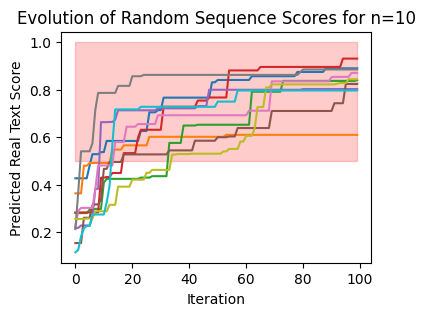

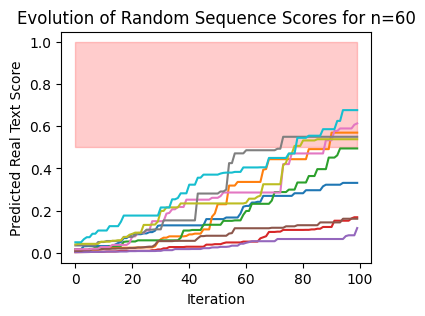

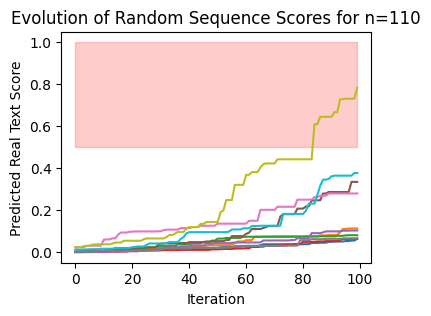

In [67]:
h = adversarial_attack(model_boosted, max_ite=max_adv_ite, samples=10, plot=True)

In [68]:
print("Adv @10: ", np.sum(h[0, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @60: ", np.sum(h[1, :, -1] >= 0.5)/len(h[0, :, -1]))
print("Adv @110: ", np.sum(h[2, :, -1] >= 0.5)/len(h[0, :, -1]))

Adv @10:  1.0
Adv @60:  0.5
Adv @110:  0.1


### Evaluation

In [69]:
eval_model(model, val_loader)

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
AuC: nan


c:\Users\matti\anaconda3\envs\ai\Lib\site-packages\sklearn\metrics\_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
